In [1]:
import sys
sys.path.insert(1, '/Users/jeanettemumford/Dropbox/Research/Projects/RT_sims/Code')
from functions import *
import seaborn as sns
import pandas as pd
from scipy import signal
from scipy.stats import exponnorm, gamma

/Users/jeanettemumford/.pyenv/versions/3.8.5/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# From the paper, gamma with alpha (shape) = 1.7, beta = .4 (.49 in poster!), min = .5.  
# Maybe beta is scale and not rate?  
# They say mean = .84s, sd = .64s
# I checked with Jack and this is what they did.  Note, the scale was incorrect 
# in the paper.  Also, if you omit the loc, the mean and sd match the paper

rt_grinband_shift = gamma.rvs(a = 1.7, loc = .5, scale = .49, size = 10000)
print('using location parameter to shift')
print(rt_grinband_shift.mean())
print(rt_grinband_shift.std())

rt_grinband_not_shifted = gamma.rvs(a = 1.7, loc = 0, scale = .49, size = 10000)
print('Unshifted')
print(rt_grinband_not_shifted.mean())
print(rt_grinband_not_shifted.std())

using location parameter to shift
1.334111219495723
0.6372679363738107
Unshifted
0.8395144670436061
0.6409230704074588


shape (k)=6.629073155666152, mu (loc)=641.6105429398768,sigma (scale)=104.46417256427785, inv_lam=692.5006420747308
gamma fit to stroop
(4.096802691951067, 0.3026914066574904, 0.11010008569482506)


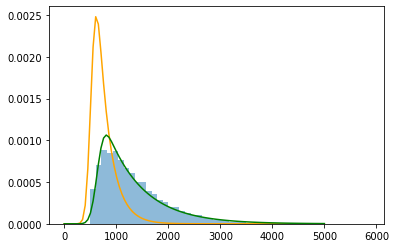

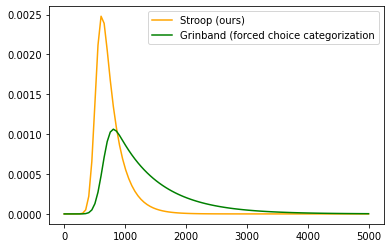

In [3]:
#further checking my exponnorm parameters are reasonable

shape_grinband_shift, mu_grinband_shift, sigma_grinband_shift  = exponnorm.fit(rt_grinband_shift*1000)
inv_lambda_grinband_shift = np.multiply(sigma_grinband_shift, 
                                            shape_grinband_shift)
print(f'shape (k)={shape_grinband_shift}, mu (loc)={mu_grinband_shift},sigma (scale)={sigma_grinband_shift}, inv_lam={inv_lambda_grinband_shift}')
x_dist = np.linspace(0, 5000, 100)
expnorm_pdf_fit_rt_grinband_shift = exponnorm.pdf(x=x_dist, 
                                                    K=shape_grinband_shift, 
                                                    loc=mu_grinband_shift,
                                                    scale=sigma_grinband_shift)
gamma_pdf = gamma.pdf(x = x_dist, a = 1.7, loc = .5*1000, scale = .49*1000)

expnorm_other = exponnorm.pdf(x=x_dist, 
                                                    K=2.94, 
                                                    loc=525.88,
                                                    scale=77.32)

data_stroop_rt = exponnorm.rvs(K=2.94, 
                                                    loc=525.88,
                                                    scale=77.32, size=5000)                                                
fit_alpha, fit_loc, fit_beta=gamma.fit(data_stroop_rt/1000)
print('gamma fit to stroop')
print((fit_alpha, fit_loc, fit_beta))

mu_explore = 930
sigma_explore = 31
lam_explore = 1/95
shape_explore  = 1 / (sigma_explore * lam_explore)
expnorm_explore = exponnorm.pdf(x=x_dist, K=shape_explore, 
                            loc=mu_explore, scale=sigma_explore) 


fig, ax = plt.subplots(1, 1)
ax.hist(rt_grinband_shift*1000, 50,  density=True, alpha = .5)
ax.plot(x_dist, expnorm_other, 'orange')
ax.plot(x_dist, expnorm_pdf_fit_rt_grinband_shift, 'green')
#ax.plot(x_dist, gamma_pdf, 'blue')
#ax.plot(x_dist, expnorm_explore, 'magenta')
plt.show()

fig, ax = plt.subplots(1, 1)
#ax.hist(rt_grinband_shift*1000, 50,  density=True, alpha = .5)
ax.plot(x_dist, expnorm_other, 'orange', label='Stroop (ours)')
ax.plot(x_dist, expnorm_pdf_fit_rt_grinband_shift, 'green', label='Grinband (forced choice categorization')
#ax.plot(x_dist, gamma_pdf, 'blue')
#ax.plot(x_dist, expnorm_explore, 'magenta')
plt.legend()
plt.show()


In [4]:
n_trials = 30
scan_length = 225
repetition_time = 1
# Parameters for RT distribution
# For midusref (avg within sub): mu=696.5963 sigma=118.8768 tau=202.3774 
#mu_expnorm = 530
#lam_expnorm = 1 / 170
#sigma_expnorm = 77

mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift

max_rt = 8000
min_rt = 50
event_duration = .5
beta_scales_yes = 5
beta_scales_no = 30
nsim = 100
center_rt=True

In [5]:
ISI_min = 3
ISI_max = 6
win_sub_noise_sd_range_scales_yes = [1.2, 1.75,  3, 4, 10]
win_sub_noise_sd_range_scales_no = [.25,  .35, .5,  .75, 3]

est_true_cor = calc_cor_over_noise_range(100, n_trials, scan_length, 
                    repetition_time, mu_expnorm,
                    lam_expnorm, sigma_expnorm, max_rt,
                    min_rt, event_duration, ISI_min, ISI_max, 
                    win_sub_noise_sd_range_scales_yes,
                    win_sub_noise_sd_range_scales_no, center_rt,
                    beta_scales_yes, beta_scales_no)
print('correlation estimates: scales yes')
print(est_true_cor['cor_est_scales_yes_filt_yes'])
print('correlation estimates: scales no')
print(est_true_cor['cor_est_scales_no_filt_yes'])


correlation estimates: scales yes
[0.40413567081551804, 0.2897077177822081, 0.17910463965239398, 0.13756853899391286, 0.0633594603339212]
correlation estimates: scales no
[0.4035506341361578, 0.2936258997199764, 0.2065919276051419, 0.12727222948371394, 0.030819353376438933]


In [ ]:
nsim_pow = 5000
hp_filter = False
ISI_min_max_vec = [(1, 3), (2, 5), (3, 6), (4, 7)]

mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift

In [ ]:
output_unmod_beta_power_grin_hp_no, output_rtmod_beta_power_grin_hp_no = \
       calc_win_sub_pow_range(n_trials, scan_length,repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, min_rt, event_duration, 
              ISI_min_max_vec, win_sub_noise_sd_range_scales_yes,
              win_sub_noise_sd_range_scales_no, center_rt, beta_scales_yes, 
              beta_scales_no, hp_filter, nsim_pow)


In [ ]:
print('NO Highpass filter, Scales = Yes, Grinband')
power_plot_1sub(output_unmod_beta_power_grin_hp_no, 
                output_rtmod_beta_power_grin_hp_no, 
                sim_type='dv_scales_yes', zoom=False)

print('NO Highpass filter, Scales = No, Grinband')
power_plot_1sub(output_unmod_beta_power_grin_hp_no, 
                output_rtmod_beta_power_grin_hp_no, 
                sim_type='dv_scales_no', zoom=False)

In [ ]:
hp_filter = True

output_unmod_beta_power_grin_hp_yes, output_rtmod_beta_power_grin_hp_yes = \
       calc_win_sub_pow_range(n_trials, scan_length,repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, min_rt, event_duration, 
              ISI_min_max_vec, win_sub_noise_sd_range_scales_yes,
              win_sub_noise_sd_range_scales_no, center_rt, beta_scales_yes, 
              beta_scales_no, hp_filter, nsim_pow)


In [ ]:
print('Yes Highpass filter, Scales = Yes, Grinband')
power_plot_1sub(output_unmod_beta_power_grin_hp_yes, 
                output_rtmod_beta_power_grin_hp_yes, 
                sim_type='dv_scales_yes', zoom=False)

print('Yes Highpass filter, Scales = No, Grinband')
power_plot_1sub(output_unmod_beta_power_grin_hp_yes, 
                output_rtmod_beta_power_grin_hp_yes, 
                sim_type='dv_scales_no', zoom=False)

In [ ]:
# Adjust noise for stroop settings
mu_expnorm = 525
lam_expnorm = 1 / 166
sigma_expnorm = 77
hp_filter = True

win_sub_noise_sd_range_scales_yes = [.5, .75, 1.25, 2.75, 7]
win_sub_noise_sd_range_scales_no = [.25, 0.35, 0.5, 0.8, 3]
print(win_sub_noise_sd_range_scales_yes)
print(win_sub_noise_sd_range_scales_no)
print(beta_scales_yes)
print(beta_scales_no)


est_true_cor = calc_cor_over_noise_range(100, n_trials, scan_length, 
                    repetition_time, mu_expnorm,
                    lam_expnorm, sigma_expnorm, max_rt,
                    min_rt, event_duration, ISI_min, ISI_max, 
                    win_sub_noise_sd_range_scales_yes,
                    win_sub_noise_sd_range_scales_no, center_rt,
                    beta_scales_yes, beta_scales_no)
print('correlation estimates: scales yes')
print(est_true_cor['cor_est_scales_yes_filt_yes'])
print('correlation estimates: scales no')
print(est_true_cor['cor_est_scales_no_filt_yes'])

In [ ]:
output_unmod_beta_power_stroop_hp_yes, output_rtmod_beta_power_stroop_hp_yes = \
       calc_win_sub_pow_range(n_trials, scan_length,repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, min_rt, event_duration, 
              ISI_min_max_vec, win_sub_noise_sd_range_scales_yes,
              win_sub_noise_sd_range_scales_no, center_rt, beta_scales_yes, 
              beta_scales_no, hp_filter, nsim_pow)

In [ ]:
print('Yes Highpass filter, Scales = Yes, Stroop')
power_plot_1sub(output_unmod_beta_power_stroop_hp_yes, 
                output_rtmod_beta_power_stroop_hp_yes, 
                sim_type='dv_scales_yes', zoom=False)

print('Yes Highpass filter, Scales = No, Stroop')
power_plot_1sub(output_unmod_beta_power_stroop_hp_yes, 
                output_rtmod_beta_power_stroop_hp_yes, 
                sim_type='dv_scales_no', zoom=False)

In [ ]:
output_unmod_beta_power_grin = output_unmod_beta_power_grin_hp_yes
output_rtmod_beta_power_grin = output_rtmod_beta_power_grin_hp_yes
output_unmod_beta_power_stroop = output_unmod_beta_power_stroop_hp_yes
output_rtmod_beta_power_stroop = output_rtmod_beta_power_stroop_hp_yes

isi_labels = list(output_unmod_beta_power_grin.keys())
isi_labels = isi_labels[0:3]
nrows_plot = 4
ncols_plot = len(isi_labels)
fig, axs = plt.subplots(nrows_plot+1, ncols_plot, sharex=True, sharey=True,
               figsize=(9.5, 9), gridspec_kw={"height_ratios":[0.02,1,1,1,1]})
fig.add_subplot(111, frameon=False)
#fig.suptitle("Single Subject Power", fontsize=25)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, 
                     left=False, right=False)
plt.xlabel("Effect size (correlation)", fontsize=20)
plt.ylabel("Power (within-subject)", fontsize=20)
plt.setp(axs, xlim=(0.05, .3))
out_types = [('grin', 'scales_yes', 'Forced Choice\n Scales with RT'), 
             ('grin', 'scales_no', "Forced Choice\n Doesn't scale with RT"),
             ('stroop', 'scales_yes', 'Stroop\n Scales with RT'), 
             ('stroop', 'scales_no', "Stroop\n Doesn't scale with RT")]
for row in range(len(out_types)):
    for col in range(len(isi_labels)):
        rt_settings = out_types[row][0]
        scale_settings = out_types[row][1]
        plot_label = out_types[row][2]
        isi_settings = isi_labels[col]
        out_name_rtmod = f'output_rtmod_beta_power_{rt_settings}'
        out_name_unmod = f'output_unmod_beta_power_{rt_settings}'
        rtmod_data = vars()[out_name_rtmod]
        unmod_data = vars()[out_name_unmod]
        sim_type = f'dv_{scale_settings}'
        if scale_settings == 'scales_yes':
            correlation= \
              rtmod_data[isi_settings]['cor_est_scales_yes_filt_yes']
        else:
            correlation= \
              unmod_data[isi_settings]['cor_est_scales_no_filt_yes']
        line1, = axs[row+1, col].plot(
                     correlation, 
                     rtmod_data[isi_settings][sim_type]['RT Duration only'], 
                     'tab:blue', label = 'RT duration')
        line2, = axs[row+1, col].plot(
                    correlation, 
                    unmod_data[isi_settings][sim_type]['Impulse Duration'], 
                    'tab:green', label = 'Const (Impulse*)') 
        line3,  = axs[row+1, col].plot(
                    correlation, 
                    unmod_data[isi_settings][sim_type]['Stimulus Duration'], 
                    color='tab:purple', label = 'Const (Stimulus Duration*)')
        line4,  = axs[row+1, col].plot(
                    correlation, 
                    unmod_data[isi_settings][sim_type]['Mean RT Duration'], 
                    color='tab:red', label = 'Const (Mean RT Duration*)')
        line5,  = axs[row+1, col].plot(
                    correlation, 
                    unmod_data[isi_settings][sim_type]['No RT effect'], 
                    color='tab:olive', label = 'Const (Stimulus Duration)')
        axs[row+1, col].set_title(plot_label)
for i, ax in enumerate(axs.flatten()[:3]):
    ax.axis("off")
    ax.set_title(f'ISI=U{isi_labels[i]}', fontweight='bold', fontsize=15)
fig.subplots_adjust(hspace=.5, bottom=0.1)
fig.tight_layout()
plt.legend(handles=[line1, line2, line3, line4, line5], 
          loc='center right', bbox_to_anchor=(1.32, .5), 
          ncol=1)
plt.savefig("/Users/jeanettemumford/Desktop/draft_single_power.pdf",
            format='pdf', transparent=True, pad_inches=.1, bbox_inches='tight')
plt.show()

In [ ]:
# Plot for paper
# Assumes only 4 ISI settings were used
def power_plot_1sub_paper(output_unmod_beta_power_grin, 
                          output_rtmod_beta_power_grin, 
                          output_unmod_beta_power_stroop, 
                          output_rtmod_beta_power_stroop,zoom=False):
    isi_labels = list(output_unmod_beta_power_grin.keys())
    nrows_plot = 4
    ncols_plot = len(isi_labels)
    fig, axs = plt.subplots(nrows_plot, ncols_plot, sharex=True, sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, 
                     left=False, right=False)
    plt.xlabel("Effect size (correlation)")
    plt.ylabel("Power")
    #fig.text(0.5, 0.04, 'common X', ha='center')
    #fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
    if zoom!=False:
        plt.setp(axs, xlim=zoom)
    out_types = [('grin', 'scales_yes'), ('grin', 'scales_no'),
                 ('stroop', 'scales_yes'), ('stroop', 'scales_no')]
    for row in range(len(out_types)):
        
        for col in range(len(isi_labels)):

    for i in range(len(isi_labels)):
       



        if sim_type == 'dv_scales_yes':
            correlation = \
                output_rtmod_beta_power[isi_labels[i]]['cor_est_scales_yes_filt_yes']
        if sim_type == 'dv_scales_no':
            correlation = \
                output_unmod_beta_power[isi_labels[i]]['cor_est_scales_no_filt_yes']
        panel_row = i//ncols_plot
        panel_col = i%ncols_plot
        line1, = axs[panel_row, panel_col].plot(
                     correlation, 
                     output_rtmod_beta_power[isi_labels[i]][sim_type]['RT Duration only'], 
                     'tab:blue', label = 'RT duration')
        line2, = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_unmod_beta_power[isi_labels[i]][sim_type]['Impulse Duration'], 
                    'tab:green', label = 'Const (impulse)') 
        line3,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_rtmod_beta_power[isi_labels[i]][sim_type]['Impulse Duration'], 
                    'tab:green', linestyle = 'dashed', label = 'RT modulated (impulse)')
        line4, = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_unmod_beta_power[isi_labels[i]][sim_type]['Fixed/RT Duration (orth)'], 
                    color='tab:orange', label = 'Const (stimulus duration)') 
        line5,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_rtmod_beta_power[isi_labels[i]][sim_type]['Fixed/RT Duration (orth)'], 
                    color='tab:orange',linestyle='dashed', label = 'Orthogonalized RT duration')
        line6,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_unmod_beta_power[isi_labels[i]][sim_type]['Stimulus Duration'], 
                    color='tab:purple', label = 'Const (stimulus duration)')
        line7,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_rtmod_beta_power[isi_labels[i]][sim_type]['Stimulus Duration'], 
                    color='tab:purple',linestyle='dashed', label = 'RT modulated (stimulus duration)')
        line8,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_unmod_beta_power[isi_labels[i]][sim_type]['Mean RT Duration'], 
                    color='tab:red', label = 'Const (Mean RT duration)')
        line9,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_rtmod_beta_power[isi_labels[i]][sim_type]['Mean RT Duration'], 
                    color='tab:red',linestyle='dashed', label = 'RT modulated (mean RT duration)')
        line10,  = axs[panel_row, panel_col].plot(
                    correlation, 
                    output_unmod_beta_power[isi_labels[i]][sim_type]['No RT effect'], 
                    color='tab:olive', label = 'Const (stimulus duration)')
        axs[panel_row, panel_col].set_title(f'ISI=U{isi_labels[i]}')
    fig.tight_layout()
    plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, 
               line9, line10], 
              loc='center right', bbox_to_anchor=(panel_col+.7, panel_row/2), 
              ncol=1)
    plt.show()